<a href="https://colab.research.google.com/github/rachocr/CCADMACL_PROJECT_COM222/blob/main/KMEANS_AND_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import sys
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_csv('steam.csv')

In [3]:
data = data.dropna()

In [4]:
data.head(5)


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [45]:
from sklearn.feature_selection import VarianceThreshold

# Set a threshold (e.g., 0.01)
selector = VarianceThreshold(threshold=0.01)
selected_features = selector.fit_transform(data.select_dtypes(include=['number']))

# Get selected feature names
selected_feature_names = data.select_dtypes(include=['number']).columns[selector.get_support()]
print("Selected Features:", selected_feature_names)


Selected Features: Index(['appid', 'english', 'required_age', 'achievements', 'positive_ratings',
       'negative_ratings', 'average_playtime', 'median_playtime', 'price'],
      dtype='object')


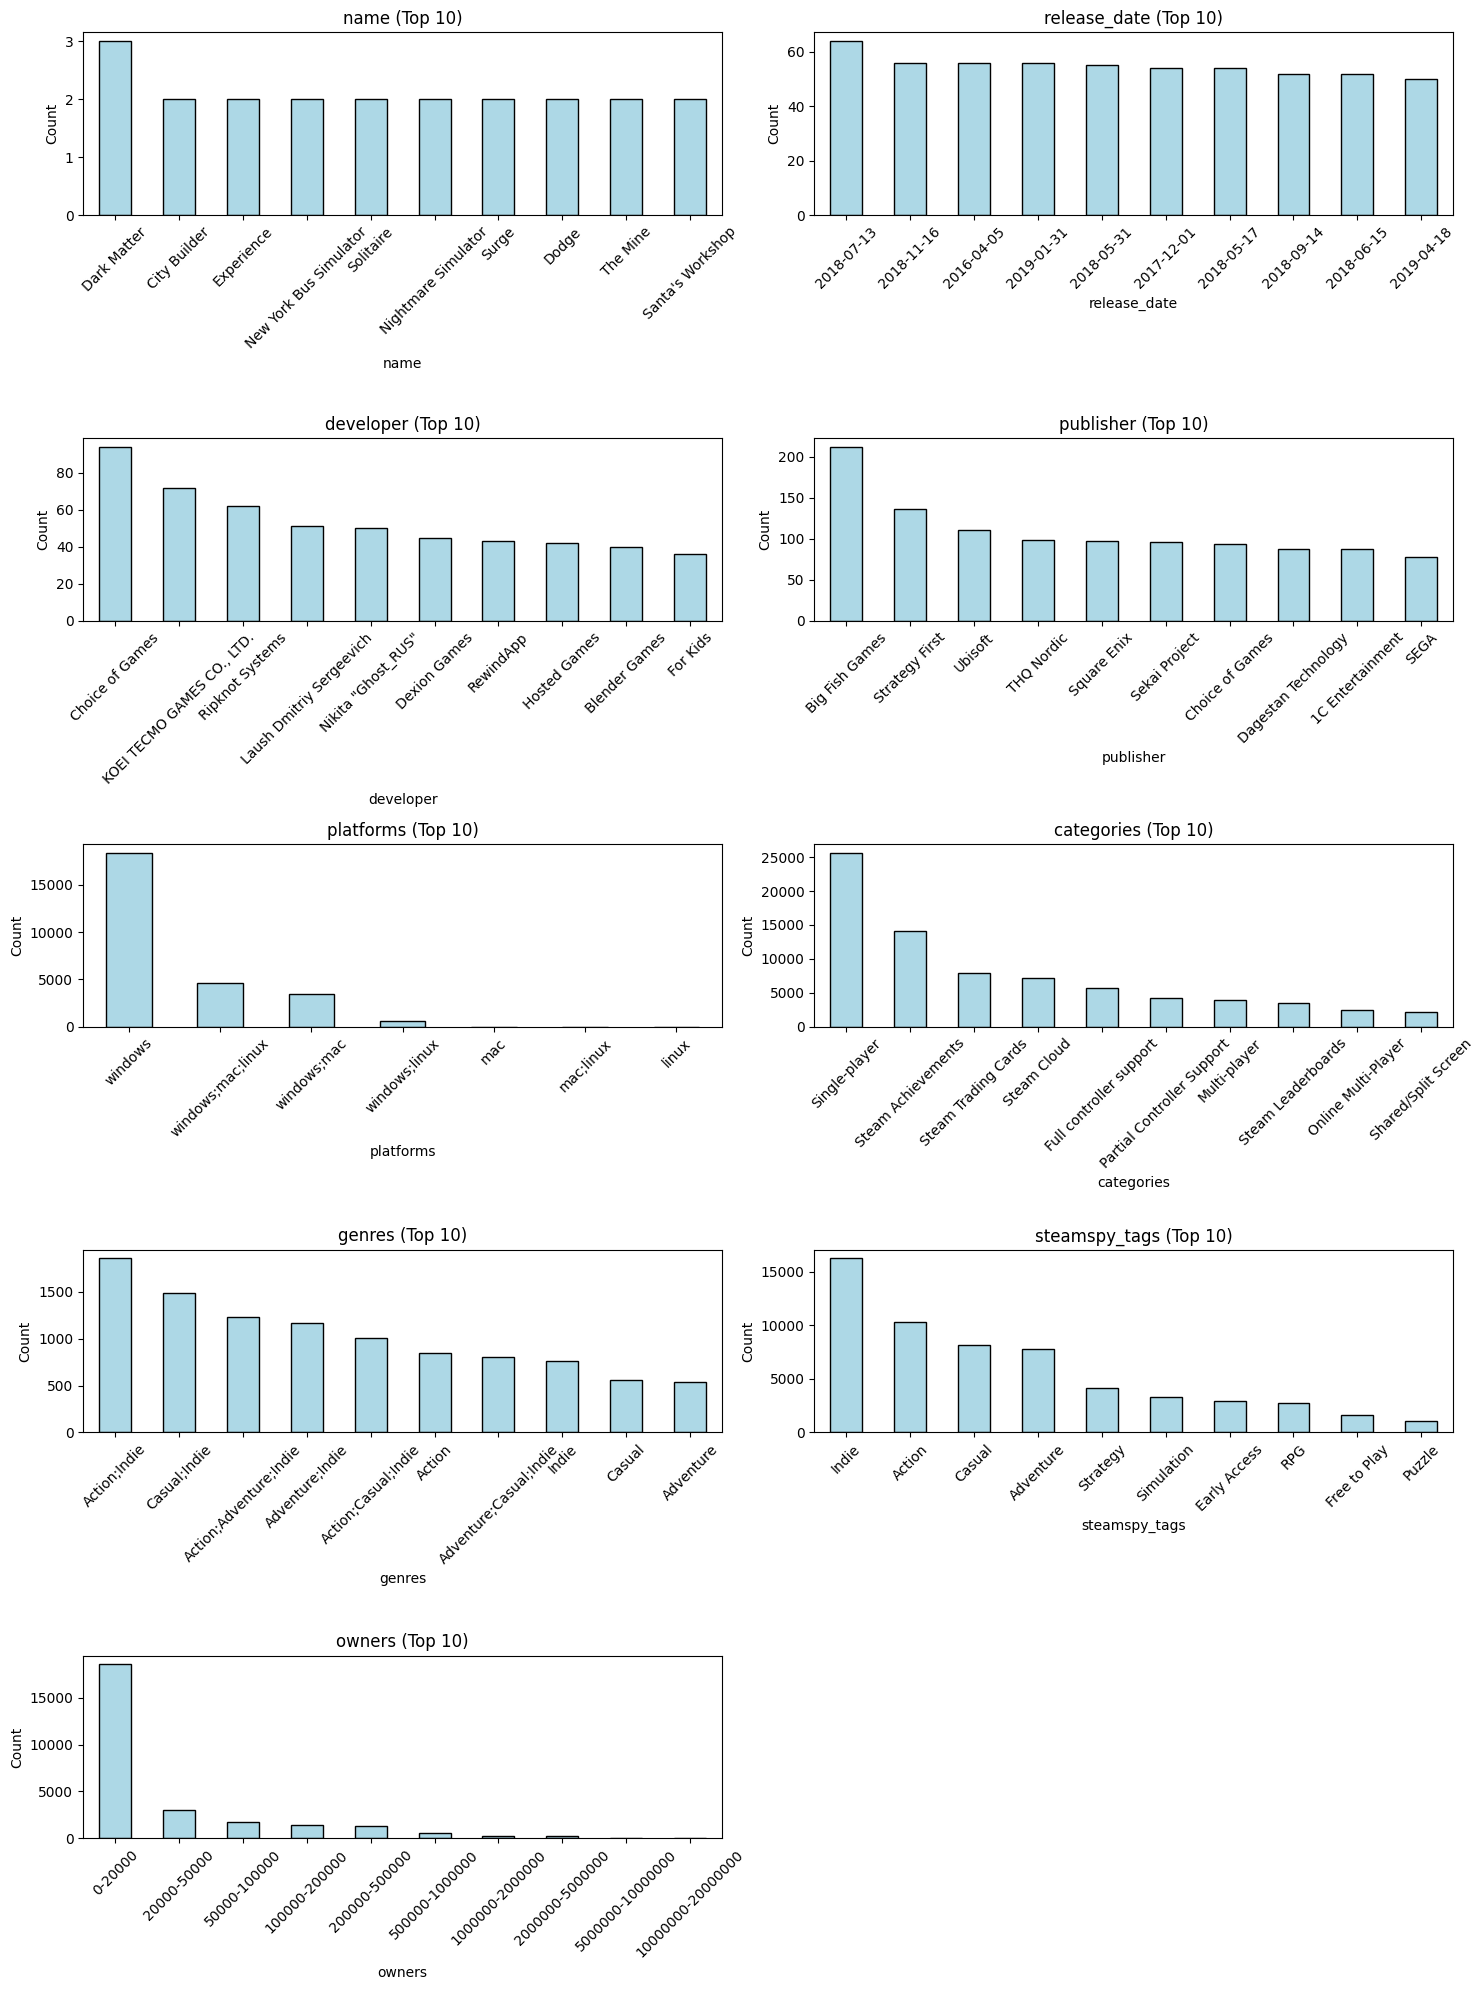

In [37]:
import matplotlib.pyplot as plt
import math

# Select categorical features
categorical_features = data.select_dtypes(include=['object']).columns

# Define grid layout: 2 columns, dynamically adjust rows
num_plots = len(categorical_features)
cols = 2  # Number of columns
rows = math.ceil(num_plots / cols)  # Calculate number of rows

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))  # Adjust figure size
axes = axes.flatten()  # Flatten in case of 1D array

for i, feature in enumerate(categorical_features):
    ax = axes[i]  # Select subplot
    # Fill missing values with 'Unknown'
    data[feature] = data[feature].fillna('Unknown')

    # For columns with multiple categories (semicolon-separated), explode the lists
    if feature in ['categories', 'steamspy_tags']:
        # Split each string by ';' (unless it's 'Unknown') and then explode the lists
        exploded_series = data[feature].apply(lambda x: x.split(';') if x != 'Unknown' else ['Unknown'])
        exploded_series = exploded_series.explode()
        top_values = exploded_series.value_counts().nlargest(10)
    else:
        top_values = data[feature].value_counts().nlargest(10)

    # Plot the top 10 most frequent values as a bar chart
    top_values.plot(kind='bar', color='lightblue', edgecolor='black', ax=ax)

    ax.set_title(f'{feature} (Top 10)', fontsize=12)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Hide empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


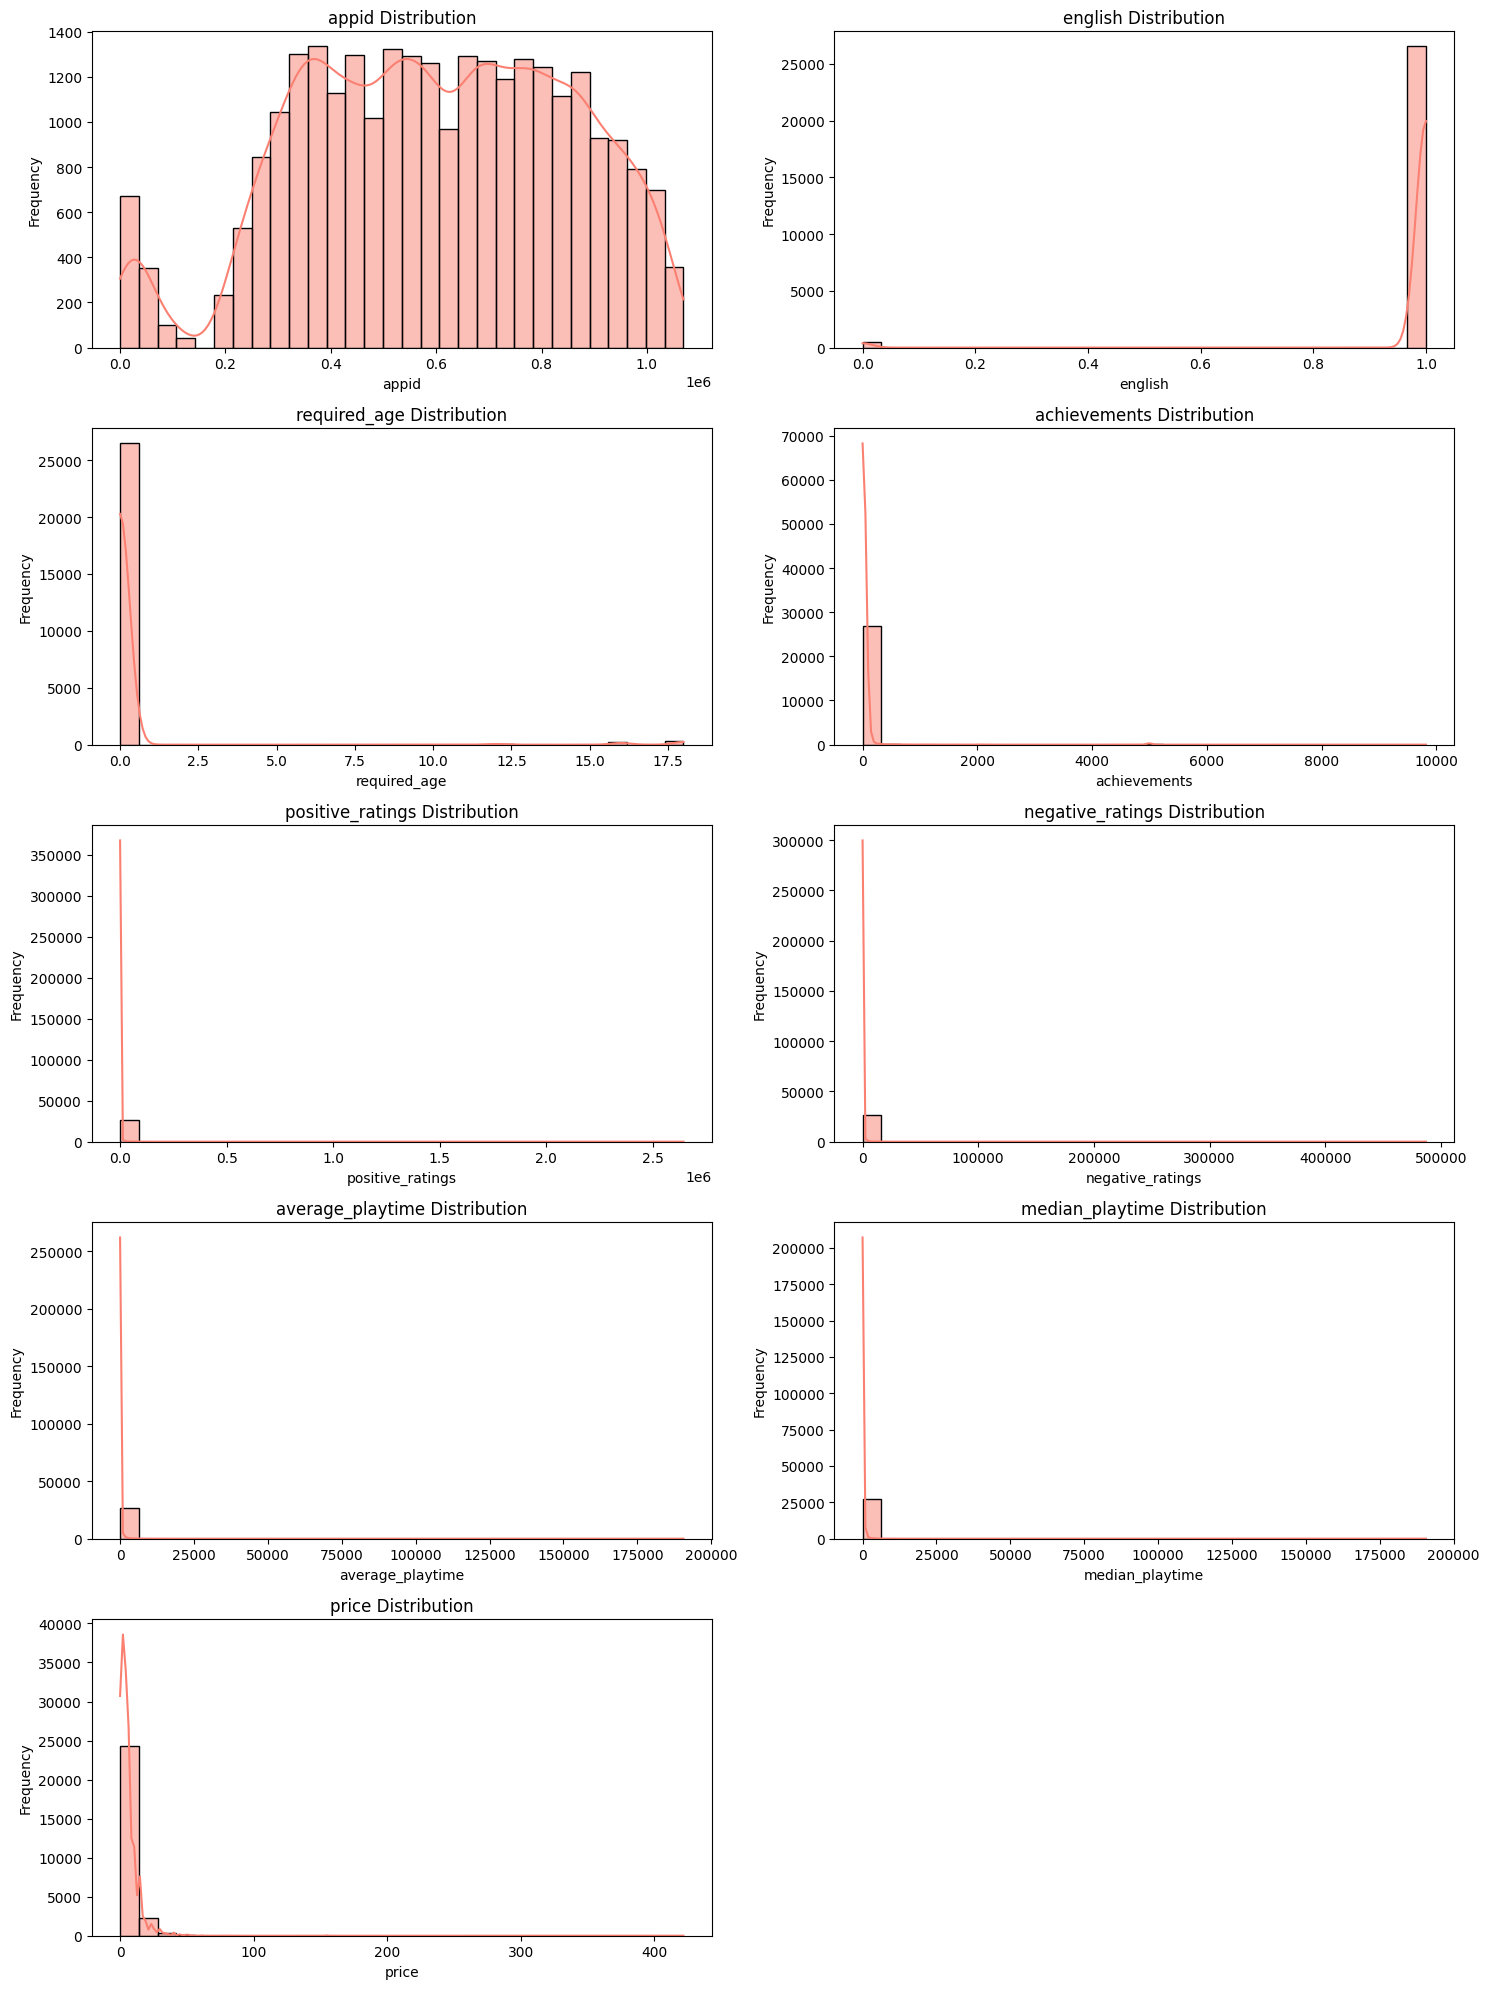

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Select numerical features from the DataFrame
numerical_features = data.select_dtypes(include=['number']).columns

# Calculate the total number of numerical features
num_plots = len(numerical_features)

# Define grid layout: 2 columns, dynamically adjust rows
cols = 2
rows = math.ceil(num_plots / cols)

# Create a figure and a set of subplots for numerical distributions
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()  # Flatten to simplify iteration

# Plot improved histogram for each numerical feature with KDE overlay
for i, feature in enumerate(numerical_features):
    ax = axes[i]

    # Use seaborn's histplot with kde=True for a smoother density estimate
    sns.histplot(data[feature], bins=30, kde=True, color='salmon', edgecolor='black', ax=ax)

    ax.set_title(f'{feature} Distribution', fontsize=12)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)

    # Optional: Uncomment the next line to set a log scale if needed for skewed data
    # ax.set_yscale('log')

# Remove any extra subplot axes if the grid is larger than the number of numerical features
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Kmeans


In [6]:
genres_encoded = data['genres'].str.get_dummies(sep=';')
owner_encoded = data['owners'].str.get_dummies()

In [7]:
features = ['positive_ratings', 'negative_ratings']
data_encoded = pd.concat([data[features], genres_encoded, data['name']], axis=1)


In [8]:
data_encoded

,positive_ratings,negative_ratings,Accounting,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Documentary,...,Simulation,Software Training,Sports,Strategy,Tutorial,Utilities,Video Production,Violent,Web Publishing,name
0,124534,3339,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Counter-Strike
1,3318,633,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Team Fortress Classic
2,3416,398,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Day of Defeat
3,1273,267,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Deathmatch Classic
4,5250,288,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Half-Life: Opposing Force
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,3,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Room of Pandora
27071,8,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Cyber Gun
27072,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Super Star Blast
27073,2,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,New Yankee 7: Deer Hunters


In [9]:
columns_to_check = ['Accounting','Animation & Modeling', 'Audio Production', 'Design & Illustration', 'Documentary', 'Early Access', 'Education', 'Game Development', 'Photo Editing'
, 'Software Training', 'Tutorial', 'Utilities', 'Video Production', 'Web Publishing']

# Loop through the columns and drop rows where the value is 1
for column in columns_to_check:
    data_encoded = data_encoded[data_encoded[column] != 1]

data_encoded = data_encoded.drop(columns_to_check , axis=1)


In [10]:
data_encoded

,positive_ratings,negative_ratings,Action,Adventure,Casual,Free to Play,Gore,Indie,Massively Multiplayer,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Violent,name
0,124534,3339,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Counter-Strike
1,3318,633,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Team Fortress Classic
2,3416,398,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Day of Defeat
3,1273,267,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Deathmatch Classic
4,5250,288,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Half-Life: Opposing Force
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,3,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,Room of Pandora
27071,8,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,Cyber Gun
27072,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,Super Star Blast
27073,2,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,New Yankee 7: Deer Hunters


In [11]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_encoded.drop(['name'], axis=1))



In [12]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)
labels = kmeans.labels_

In [13]:
data_encoded['Cluster'] = kmeans.labels_

<Figure size 800x600 with 0 Axes>

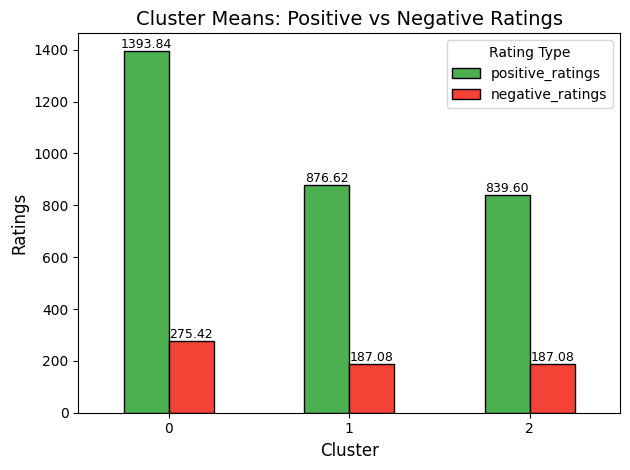

In [38]:
cluster_means = data_encoded.groupby('Cluster')[features].mean()
plt.figure(figsize=(8, 6))
ax = cluster_means[['positive_ratings', 'negative_ratings']].plot(
    kind='bar',
    color=['#4CAF50', '#F44336'],  # Green for positive, red for negative
    edgecolor='black'
)

plt.title("Cluster Means: Positive vs Negative Ratings", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Ratings", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Rating Type")
plt.tight_layout()

# Optionally, add data labels on top of each bar for clarity
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.show()

In [15]:
cluster = 0
specific_cluster_games = data_encoded[data_encoded['Cluster'] == cluster]


print(f"Games in cluster {cluster}:\n", specific_cluster_games[['name']].head(30))

Games in cluster 0:
                                 name
0                     Counter-Strike
1              Team Fortress Classic
2                      Day of Defeat
3                 Deathmatch Classic
4          Half-Life: Opposing Force
5                           Ricochet
6                          Half-Life
7     Counter-Strike: Condition Zero
8              Half-Life: Blue Shift
9                        Half-Life 2
10            Counter-Strike: Source
11                 Half-Life: Source
12             Day of Defeat: Source
13           Half-Life 2: Deathmatch
14           Half-Life 2: Lost Coast
15      Half-Life Deathmatch: Source
16          Half-Life 2: Episode One
17                            Portal
18          Half-Life 2: Episode Two
19                   Team Fortress 2
20                       Left 4 Dead
21                     Left 4 Dead 2
22                            Dota 2
24                       Alien Swarm
25  Counter-Strike: Global Offensive
26               

In [16]:
cluster = 1
specific_cluster_games = data_encoded[data_encoded['Cluster'] == cluster]


print(f"Games in cluster {cluster}:\n", specific_cluster_games[['name']].head(30))

Games in cluster 1:
                                                   name
23                                            Portal 2
88          Safecracker: The Ultimate Puzzle Adventure
148           Indiana Jones® and the Fate of Atlantis™
151                                           The Dig®
161                     Dreamfall: The Longest Journey
162                                The Longest Journey
166                    Lost Planet™: Extreme Condition
180                                Tomb Raider: Legend
185                          Runaway, A Road Adventure
186                   Runaway, The Dream of The Turtle
189                                           X-Blades
204                           Tomb Raider: Anniversary
207                            Tomb Raider: Underworld
209                                       Just Cause 2
210                           Bone: Out From Boneville
211                           Bone: The Great Cow Race
213  Strong Bad's Cool Game for Attractive P

In [17]:
cluster = 2
specific_cluster_games = data_encoded[data_encoded['Cluster'] == cluster]


print(f"Games in cluster {cluster}:\n", specific_cluster_games[['name']].head(30))

Games in cluster 2:
                                        name
30                                 Darwinia
31                                   Uplink
32                                   DEFCON
34                         Dangerous Waters
35                  Space Empires IV Deluxe
36         Disciples II: Rise of the Elves 
37           Disciples II: Gallean's Return
38      Iron Warriors: T - 72 Tank Command 
39                          Space Empires V
42                               Earth 2160
72                           X2: The Threat
73                              X3: Reunion
74                      X3: Terran Conflict
75                   X: Beyond the Frontier
76                               X: Tension
77                                X Rebirth
78                     688(I) Hunter/Killer
79                            Fleet Command
80                              Sub Command
85                     Men of War: Red Tide
86          King's Bounty: Armored Princess
87         

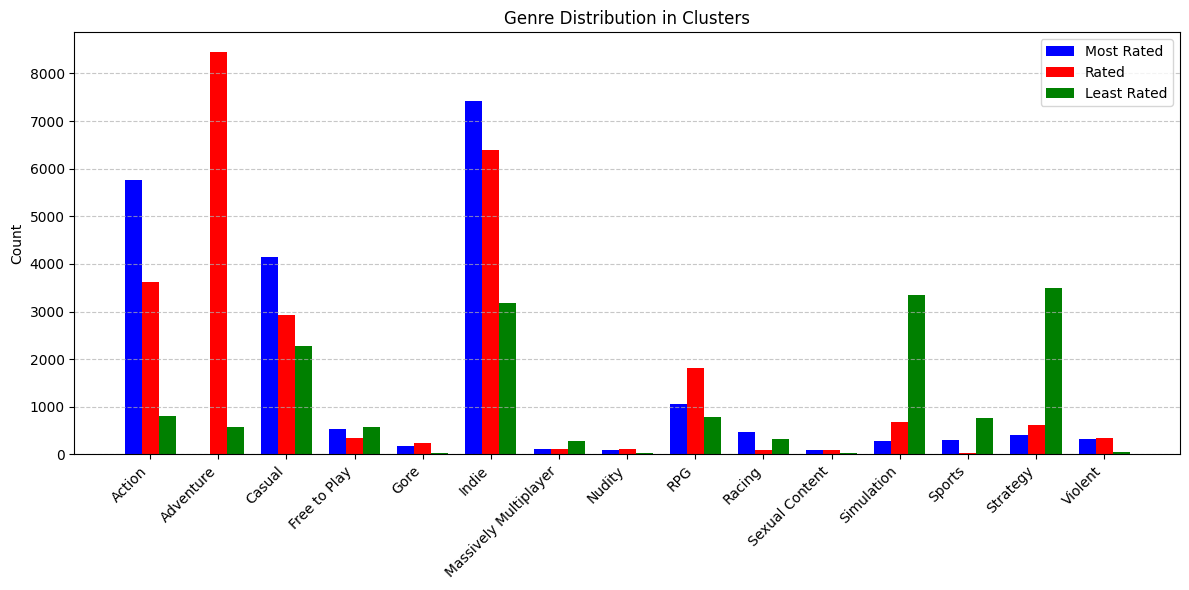

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define the genre labels
genres = ['Action', 'Adventure', 'Casual',
       'Free to Play', 'Gore', 'Indie', 'Massively Multiplayer', 'Nudity',
       'RPG', 'Racing', 'Sexual Content', 'Simulation', 'Sports', 'Strategy',
       'Violent']

# Filter data by cluster
cluster_data_0 = data_encoded[data_encoded['Cluster'] == 0]
cluster_data_1 = data_encoded[data_encoded['Cluster'] == 1]
cluster_data_2 = data_encoded[data_encoded['Cluster'] == 2]  # New cluster

# Compute genre counts per cluster
genre_counts_in_cluster_0 = cluster_data_0[genres].sum()
genre_counts_in_cluster_1 = cluster_data_1[genres].sum()
genre_counts_in_cluster_2 = cluster_data_2[genres].sum()

# Set bar width and positions
bar_width = 0.25
x = np.arange(len(genres))  # X-axis positions

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, genre_counts_in_cluster_0, width=bar_width, label='Most Rated', color='blue')
plt.bar(x, genre_counts_in_cluster_1, width=bar_width, label='Rated', color='red')
plt.bar(x + bar_width, genre_counts_in_cluster_2, width=bar_width, label='Least Rated', color='green')  # New cluster

# Formatting
plt.xticks(ticks=x, labels=genres, rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Genre Distribution in Clusters')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


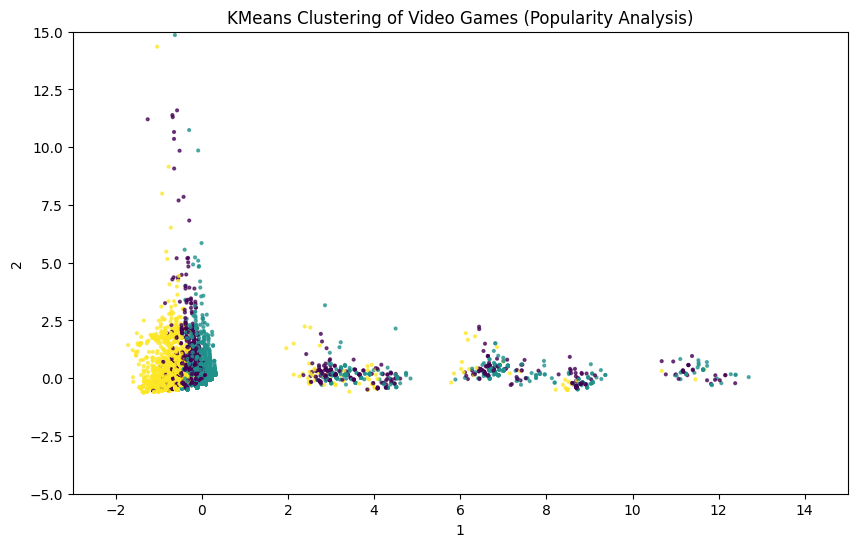

In [18]:
from sklearn.decomposition import PCA

# Reduce data to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data_encoded['Cluster'], cmap='viridis', s=4, alpha=0.7)
plt.title('KMeans Clustering of Video Games (Popularity Analysis)')
plt.xlim(-3, 15)
plt.ylim(-5, 15)
plt.xlabel('1')
plt.ylabel('2')
plt.show()

In [19]:
silhouette_avg = silhouette_score(reduced_data, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.0645


# DBSCAN


In [21]:
genres_encoded = data['genres'].str.get_dummies(sep=';')
owner_encoded = data['owners'].str.get_dummies()
features = ['positive_ratings', 'negative_ratings']
data_DBSCAN = pd.concat([data[features], genres_encoded, data['name']], axis=1)


In [22]:
columns_to_check = ['Accounting','Animation & Modeling', 'Audio Production', 'Design & Illustration', 'Documentary', 'Early Access', 'Education', 'Game Development', 'Photo Editing'
, 'Software Training', 'Tutorial', 'Utilities', 'Video Production', 'Web Publishing']

# Loop through the columns and drop rows where the value is 1
for column in columns_to_check:
    data_DBSCAN = data_DBSCAN[data_DBSCAN[column] != 1]

data_DBSCAN = data_DBSCAN.drop(columns_to_check , axis=1)

In [23]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_DBSCAN.drop(['name'], axis=1))

In [24]:
data_DBSCAN

,positive_ratings,negative_ratings,Action,Adventure,Casual,Free to Play,Gore,Indie,Massively Multiplayer,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Violent,name
0,124534,3339,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Counter-Strike
1,3318,633,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Team Fortress Classic
2,3416,398,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Day of Defeat
3,1273,267,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Deathmatch Classic
4,5250,288,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Half-Life: Opposing Force
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,3,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,Room of Pandora
27071,8,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,Cyber Gun
27072,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,Super Star Blast
27073,2,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,New Yankee 7: Deer Hunters


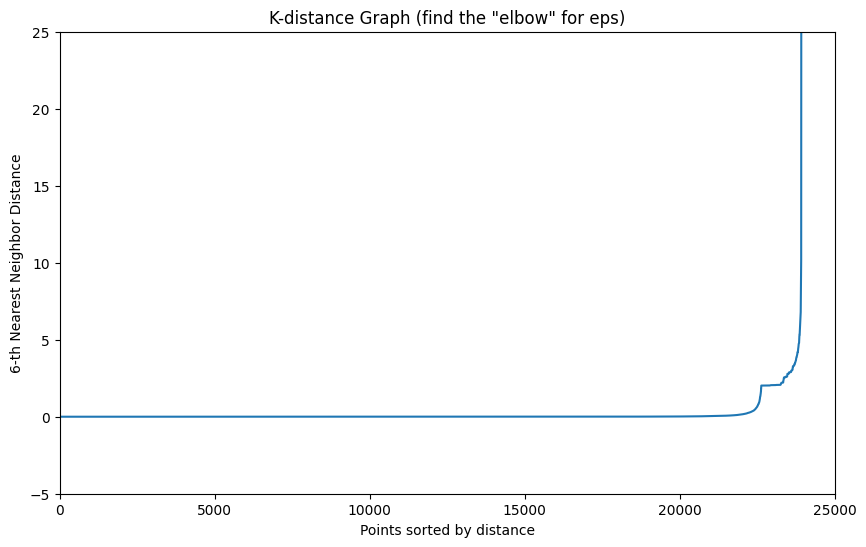

In [25]:
min_samples = 6
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# Sort distances for plotting
distances = np.sort(distances[:, min_samples - 1], axis=0)

# Plot the K-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph (find the "elbow" for eps)')
plt.xlim(-5, 25000)
plt.ylim(-5, 25)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.show()

In [26]:
dbscan = DBSCAN(eps=7, min_samples=6)
dbscan_labels = dbscan.fit_predict(scaled_data)
data_DBSCAN['DBSCAN_Cluster'] = dbscan_labels

In [27]:
for cluster_id in set(dbscan_labels):
    if cluster_id != -1:
        print(f"Games in DBSCAN cluster {cluster_id}:\n")
        cluster_games = data_DBSCAN[data_DBSCAN['DBSCAN_Cluster'] == cluster_id][['name']]
        print(cluster_games.head())

Games in DBSCAN cluster 0:

                        name
0             Counter-Strike
1      Team Fortress Classic
2              Day of Defeat
3         Deathmatch Classic
4  Half-Life: Opposing Force
Games in DBSCAN cluster 1:

                    name
189             X-Blades
190     Two Worlds II HD
685             The Void
1209             Demigod
2487  Hero and Daughter+
Games in DBSCAN cluster 2:

                                        name
471      Penumbra: Black Plague Gold Edition
1900  Deadly Premonition: The Director's Cut
2535                                Darkwood
5431          Redemption: Saints And Sinners
5953                                  Mortos
Games in DBSCAN cluster 3:

                    name
473    Penumbra Overture
1430  Zombie Playground™
1468              Lucius
1501    Zombie Driver HD
1804          Inquisitor
Games in DBSCAN cluster 4:

                   name
1905  Knytt Underground
2215  Vanguard Princess
3352   Agents of Mayhem
6261    Caladrius Bl

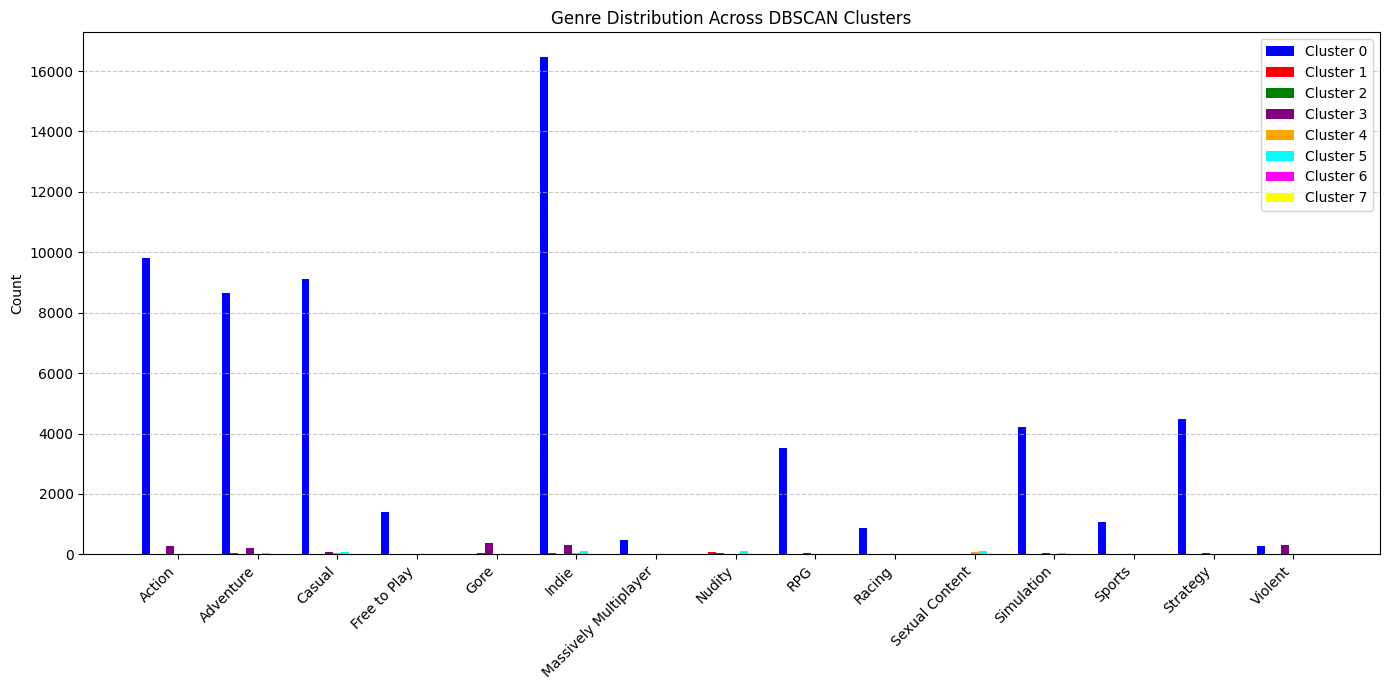

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define the genre labels
genres = ['Action', 'Adventure', 'Casual', 'Free to Play', 'Gore', 'Indie',
          'Massively Multiplayer', 'Nudity', 'RPG', 'Racing', 'Sexual Content',
          'Simulation', 'Sports', 'Strategy', 'Violent']

# Extract data for each cluster
clusters = range(8)  # DBSCAN clusters 0 to 7
cluster_data = {cluster: data_DBSCAN[data_DBSCAN['DBSCAN_Cluster'] == cluster] for cluster in clusters}

# Compute genre counts for each cluster
genre_counts = {cluster: cluster_data[cluster][genres].sum() for cluster in clusters}

# Set bar width and positions
bar_width = 0.1
x = np.arange(len(genres))  # X-axis positions

# Colors for each cluster
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow']

# Create the plot
plt.figure(figsize=(14, 7))

for i, cluster in enumerate(clusters):
    plt.bar(x + (i - len(clusters)/2) * bar_width, genre_counts[cluster],
            width=bar_width, label=f'Cluster {cluster}', color=colors[i])

# Formatting
plt.xticks(ticks=x, labels=genres, rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Genre Distribution Across DBSCAN Clusters')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [29]:
noise_games = data_DBSCAN[data_DBSCAN['DBSCAN_Cluster'] == -1]
if len(noise_games) > 0:
    print(f"\nNoise points (outliers, DBSCAN label = -1):")
    print(noise_games[['name',]])


Noise points (outliers, DBSCAN label = -1):
                                   name
19                      Team Fortress 2
22                               Dota 2
25     Counter-Strike: Global Offensive
121                         Garry's Mod
1467                           PAYDAY 2
1506                               DayZ
2016                               Rust
2031                     Rocket League®
2478                 Grand Theft Auto V
4712              ARK: Survival Evolved
7809                   Z1 Battle Royale
12836     PLAYERUNKNOWN'S BATTLEGROUNDS
15905                      Dragon Glory
16940      SCHOOL SIMULATOR MULTIPLAYER


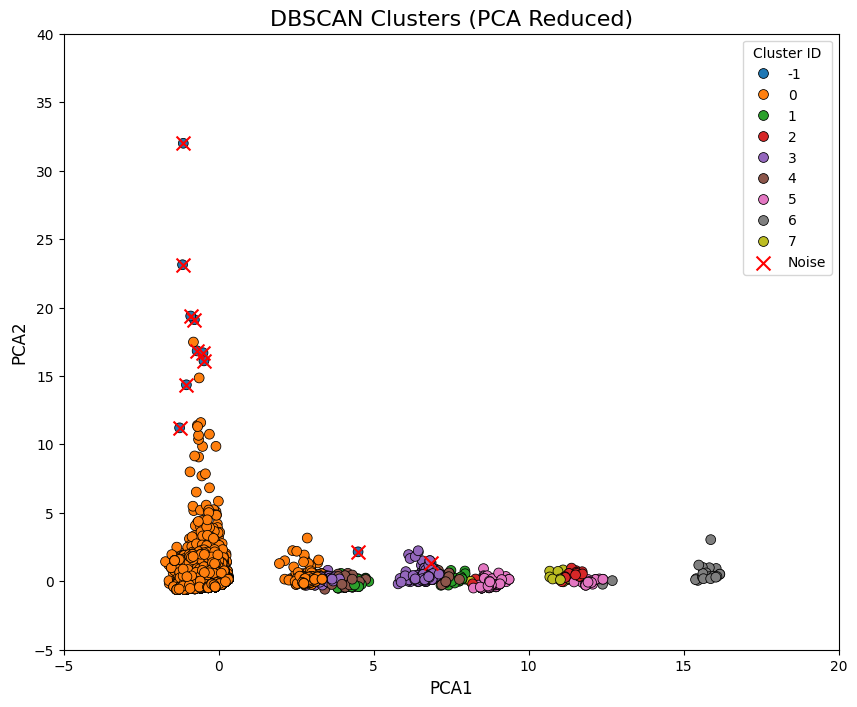

In [30]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)


data_plot = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
data_plot['Cluster'] = dbscan_labels

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data_plot, palette='tab10', marker='o', s=50, edgecolor='black')

# Highlighting noise points (DBSCAN label -1)
plt.scatter(data_plot[data_plot['Cluster'] == -1]['PCA1'],
            data_plot[data_plot['Cluster'] == -1]['PCA2'],
            color='red', label='Noise', s=100, marker='x')

plt.title('DBSCAN Clusters (PCA Reduced)', fontsize=16)
plt.xlim(-5, 20)
plt.ylim(-5, 40)

plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend(title="Cluster ID", loc='upper right')
plt.show()

In [31]:
silhouette_avg = silhouette_score(reduced_data, data_DBSCAN['DBSCAN_Cluster'])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.8517
